In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'SVM(C=0.1)特徴量ミニマム'
notebook_name = '043'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

043_submission.csv 043


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', StandardScaler(), discrete_features),
            ('categorical', 'passthrough', categorical_features)
        ]
    )
    clf = SVC(random_state=SEED, C=0.1, class_weight='balanced')
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
for c in categorical_features:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

categorical_features_1hot = []
for c in categorical_features:
    categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
print(categorical_features_1hot)

features = discrete_features + categorical_features_1hot

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['numRunners', 'S', 'inningNo', 'B', 'O', 'totalPitchingCount']
['b1_1', 'b2_1', 'b3_1', 'batterID_0', 'batterID_2', 'batterID_5', 'batterID_9', 'batterID_11', 'batterID_12', 'batterID_15', 'batterID_18', 'batterID_19', 'batterID_21', 'batterID_22', 'batterID_26', 'batterID_27', 'batterID_28', 'batterID_29', 'batterID_31', 'batterID_34', 'batterID_36', 'batterID_37', 'batterID_39', 'batterID_42', 'batterID_45', 'batterID_47', 'batterID_50', 'batterID_55', 'batterID_56', 'batterID_58', 'batterID_60', 'batterID_67', 'batterID_70', 'batterID_72', 'batterID_73', 'batterID_75', 'batterID_80', 'batterID_82', 'batterID_84', 'batterID_85', 'batterID_87', 'batterID_89', 'batterID_91', 'batterID_98', 'batterID_102', 'batterID_103', 'batterID_105', 'batterID_106', 'batterID_111', 'batterID_112', 'batterID_114', 'batterID_117', 'batterID_118', 'b

In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features_1hot)
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[1167 1804  301  338  641  366   11  438]
 [ 505 1805  154  258  390  282    3  349]
 [ 396  539  261  296  453  261    2  185]
 [ 283  408  117  295  323  164    1  118]
 [  76  116   30   42  182   60    0   34]
 [  16   29    3    8    3   87    0    4]
 [   0    0    0    0    0    0    8    0]
 [   4    4    1    0    4    1    0   82]]

**********Confusion matrix for validation set (Fold 1)**********
[[270 453  77  94 164 110   3  96]
 [133 426  36  75 106  68   2  90]
 [ 97 139  61  65 115  73   0  49]
 [ 66  92  46  50  94  53   0  26]
 [ 18  33   8  12  30  25   0   9]
 [  6   6   3   5   5   7   0   5]
 [  2   0   1   0   0   0   0   0]
 [  2   7   2   2   4   4   0   3]]

**********Confusion matrix for train set (Fold 2)**********
[[1173 1839  708  164  550  233    8  391]
 [ 515 1824  369  117  378  197    6  340]
 [ 404  546  669   88  349  130    1  206]
 [ 282  394  411  101  270  103    1  147]
 [  76  121   9

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.247480,0.141532
std,0.005617,0.004658
min,0.242007,0.134498
25%,0.243778,0.140400
50%,0.247387,0.141220
75%,0.247663,0.145728
max,0.256564,0.145815


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,7,0,1
2,2,0,7,0,1
3,3,2,7,0,1
4,4,4,3,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,4,0,5
17130,16833,1,1,0,5
17133,9762,1,1,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.769276,3.031997,5.186633,6.235405,7.256962,1.824770,-0.271598,4.126220,27446,1
1,6.194088,2.076682,6.223330,6.209053,4.180381,0.733297,-0.248344,3.084667,113,1
2,6.268831,7.285489,4.115670,2.779064,1.738240,0.729441,-0.227729,5.195773,4479,1
3,6.276480,7.286512,4.137266,5.219373,1.762617,0.717944,-0.283176,3.004291,29080,1
4,7.269719,5.201628,6.227870,4.192912,2.984785,0.722455,-0.228960,1.774582,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,6.250559,7.293337,3.837183,1.804415,5.184319,2.830059,-0.290762,0.808316,24272,5
33804,2.768025,1.725700,6.281959,7.281210,4.274340,5.254581,-0.295645,0.733511,29106,5
33805,1.753967,0.723380,5.279412,7.284997,4.202893,6.262632,-0.304655,3.221134,20679,5
33806,7.287200,1.768615,4.252277,5.251393,6.285520,2.758072,-0.289620,0.709208,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,27.938735,36.415314,15.197490,15.247745,3.876707,23.757522,-1.450475,20.399668
1,1,31.378895,36.466765,22.661005,16.843922,7.722855,21.292101,-1.460807,4.782848
2,2,9.808451,4.762170,31.301068,26.190698,36.382111,18.534664,-1.427211,15.008470
3,3,31.422430,36.458538,15.373972,11.009567,13.362855,14.511915,-1.482212,17.674181
4,4,31.378823,36.440570,21.291485,12.205803,11.138042,7.003201,-1.466561,21.071782
...,...,...,...,...,...,...,...,...,...
33803,33803,36.411803,24.178976,29.246474,24.194424,16.377729,9.006241,-1.458796,3.607871
33804,33804,31.390264,36.466132,17.447183,25.002049,14.657568,4.783806,-1.500081,11.523245
33805,33805,31.367403,36.431230,13.524721,24.136089,9.869403,3.704954,-1.482484,22.976760
33806,33806,3.725410,11.381095,19.524584,26.093259,32.221614,33.295598,-1.383192,15.905029


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,1
33806,33806,5


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.196492
1    0.438861
2    0.073415
3    0.072054
4    0.135086
5    0.038068
6    0.000089
7    0.045936
Name: y, dtype: float64

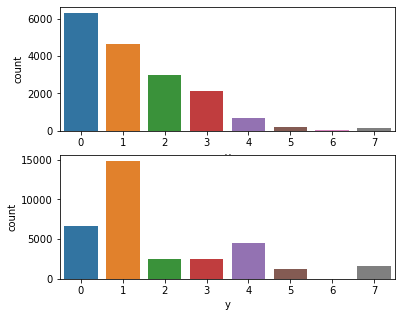

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.24747979912410814, 0.14153210114030065)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"043_submission.csv","Stratified-Kfold(K=5)","0.247480","0.141532","","SVM(C=0.1)特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 1.14 s


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 0 ns


In [21]:
imp_df

""


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [23]:
coef_df

""
